In [4]:
#ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from scipy.stats import zscore
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [5]:
#titanicCSVファイルをデータフレームにする
#Survived SibSp 兄弟　　Parch両親子供の数　Cabin　部屋番号　Embarked 乗船した港
train_df = pd.read_csv('/Users/se-ji/Desktop/titanic/titanic_train.csv')
test_df =  pd.read_csv('/Users/se-ji/Desktop/titanic/titanic_test.csv')

In [6]:
#サンプルでデータを見てみる
train_df.sample()
#欠損値確認
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


前処理
前処理とは、後の分析処理を円滑に進めていくにあたって、予めデータを使用しやすい形に整理しておくことである。

具体的には
①欠損値の補完：欠損値を持つサンプルの削除、平均値や回帰による補完など行う。→分析やさらなるデータ加工の手間を省く。分析結果へのバイアスとなるのを防ぐ
②外れ値の処理：統計的な分布に従っていないものを除外、クラスタリングした際に小さいクラスターに所属するものを除外→外れ値を処理することで、本来の性質と異なる結果が得られることを防ぐ。
③連続値の離散化：連続値を等間隔でカテゴリー化する。→分析結果の解釈がしやすくなる。
などが挙げられる。

データを確認する際には、
①欠損値がどれほどあるかを調べる。
②外れ値と思われるデータが存在するかを調べる。→データの分布を見てみる。
③連続データや文字データなど、保持してるデータがモデルに直接当てはめられる形になっているかの確認。
などを行う。

In [8]:
#fillnaで欠損値の値を-0.5に置き換えている。その後数値データをカテゴリー変数へと分け、それぞれ定義している。具体的には、
#-1≦Age＜０: Unknown 
#0≦Age＜5:Baby 
#5≦Age＜12:Child
#12≦Age＜18:Teenager
#18≦Age＜25:Student
#25≦Age＜35:Young Adult
#35≦Age＜60:Adult
#60≦Age＜120:Senior と値の範囲をbinsで設定し９段階に分けている。このようにカテゴリー化することで、分析の際に説明がしやすいことが上げられる。

def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

#fillnaで欠損値を”N”で置き換えた後、文字列の一文字目だけを取り出し、置き換えている。
#欠損値をなくすことで、分析の精度を高める。カテゴリーの数を減らすことで分析しやすくしている。
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

#ageと同様に数値データをカテゴリー変数へと変更している。その際、基準として４分位数を使い、全体の２５％点、５０％点、７５％点を境目としている。
#４分位点を用いることで、データが均等に４分割されている点も、分析の際に説明がしやすくなる工夫であるといえる。
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

#名前の行の０番目を取り出しLnameの列を作る。また敬称が1番目にかかれているのでそれを取り出し、NamePrefixとして別の列を作成する。
#名字を抽出することで、家族の生死の状況が把握できるようにする。
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
#Ticket Name Embarkedの列を削除する
#分析に必要のないデータを消去しておくことで、視認性を高くする。
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [9]:
train_df = transform_features(train_df)
test_df = transform_features(test_df)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.
5,6,0,3,male,Unknown,0,0,2_quartile,N,"Moran,",Mr.
6,7,0,1,male,Adult,0,0,4_quartile,E,"McCarthy,",Mr.
7,8,0,3,male,Baby,3,1,3_quartile,N,"Palsson,",Master.
8,9,1,3,female,Young Adult,0,2,2_quartile,N,"Johnson,",Mrs.
9,10,1,2,female,Teenager,1,0,3_quartile,N,"Nasser,",Mrs.


In [10]:
#トレインデータとテストデータを合わせ、LabelEncoderを用いてカテゴリーデータを数値ラベルに置き換える。
#文字列を数値データに変えることで、分析をしやすくする。（説明変数に入れられる形にしている）
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

train_df, test_df = encode_features(train_df, test_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


モデル選択（分類）

今回は乗客の生死を予想する２クラス分類の問題であるため、２値分類ができるモデルを選ぶ。
①ロジスティック回帰　アウトプットとしての数値が０〜１の間の値になり、確率的な解釈が可能なモデル。データの分布が線形性であることを仮定している。
長所：学習時間が短い、中身がわかりやすい、アウトプットの値を確率として解釈できる。短所：高い精度が望めない、線形分離ができない場合に用いるとほとんど分類ができない、説明変数に名義尺度を用いることができず、ダミー変数に変換しなければならない。
http://blogs.teradata.com/international/ja/hhg10/
http://tjo.hatenablog.com/entry/2015/03/26/190000
http://www.ibaraki-kodomo.com/toukei/logis.html

②ランダムフォレスト　決定木モデルを複数作り、アンサンブル学習を行うことで精度を高める。
長所：説明変数が多くなってもうまく働きやすい、並列化もでき学習と評価の時間が短い、中身がわかりやすい。
短所：多くのデータと説明変数が必要、過学習になりやすい、アルゴリズムはシンプルであるものの線形回帰に比べるとメモリなどの消費が多い。
https://www.slideshare.net/HitoshiHabe/ss-58784421
https://www.slideshare.net/teppeibaba5/ss-37143977

③サポートベクターマシン　　ニューロンモデルとしては最も単純な線形しきい素子を用いて２クラスのパターン識別器を構成する手法
長所：データの特徴の次元が大きい場合でも精度が高く出る、汎化能力が高い、マージンを最大化させるという識別境界の位置を決定する明確な基準を持っている。　短所：基本的には２クラス分類のみに用い多クラス分類の場合は複数を組み合わせる必要がある、データが増えると学習時間が膨大になる、正則化やカーネル関数の設定、スラック変数などのパラメータの調整が必要になる。
http://drilldripper.hatenablog.com/entry/2017/02/07/183412
https://www.slideshare.net/mknh1122/svm-13623887

モデル選択をする上で判断基準になるものは、①問題の種類（分類か回帰か異常の検出か）②予測の精度③学習時間④線形性⑤中身のわかりやすさ（何故そのような結論に至ったのかの説明がつくかどうか）などが挙げられる。

In [11]:
#データの可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

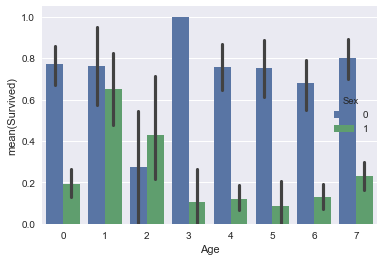

In [12]:
#survived 1 生存者　sex 1 male 0 female
sns.barplot(x="Age", y="Survived", hue="Sex", data=train_df);

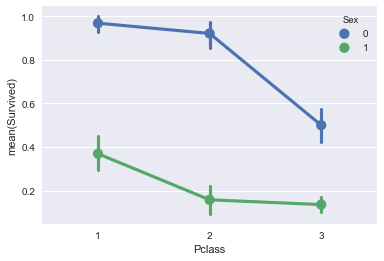

In [13]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_df,);

データ可視化の考察
上記の可視化の結果から、child（５〜１２）の年齢層を除いて、男性よりも女性の生存率が高いことがわかる。
また年齢別に見るとBaby（０〜４）、Senior（６０〜１２０）の生存率が比較的高いと言える。
乗っていたクラス別に見ると、男女ともに１のクラスに乗っている人の生存率が高く、３のクラスに乗っている人の生存率は最も低い。

性別・年齢・Pクラスが生死を分ける重要なファクターであると予想される。生存の予想という観点から、これらがどういう場合に生死を分けたかの中身が見えるモデルを選択するほうが好ましいといえる。また、内容的に急ぎではないようであれば、モデルが複雑で学習に時間がかかっても精度が高いものを選択するのが良いと考える。

In [14]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=1)

In [15]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
301,3,1,6,2,0,2,7,502,19
309,1,0,7,0,0,3,4,259,16
516,2,0,7,0,0,1,5,439,20
120,2,1,4,2,0,3,7,337,19
570,2,1,3,0,0,1,7,317,19
730,1,0,7,0,0,3,1,15,16
228,2,1,5,0,0,1,7,243,19
563,3,1,6,0,0,1,7,729,19
311,1,0,5,2,2,3,1,693,16
613,3,1,6,0,0,0,7,353,19


決定木とランダムフォレストモデルについて
決定木：樹木状のモデルを使って要因を分析し、その結果から境界線を探すことで予測、分類を行う手法。回帰で用いられるものを回帰木、分類で用いられるものを分類木と呼ぶ。IF-ELIF-ELIF...-ELSE の形で表せるように分岐を作って分類するモデル
ランダムフォレスト：決定木モデルを複数作り、アンサンブル学習を行うことで精度を高める。
長所：説明変数が多くなってもうまく働きやすい、並列化もでき学習と評価の時間が短い、中身がわかりやすい。
短所：多くのデータと説明変数が必要、過学習になりやすい、アルゴリズムはシンプルであるものの線形回帰に比べるとメモリなどの消費が多い。

In [16]:
#ランダムフォレストモデル作成
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,random_state=2)
clf = clf.fit(X_train, y_train)

In [17]:
#精度の確認
my_score = clf.score(X_test, y_test)
my_score

0.79329608938547491

ハイパーパラメータ
ハイパーパラメータとは、機械学習のモデルが持つパラメータのうちデータからの学習では値が決まらないパラメータのことである。

ランダムフォレストのハイパーパラメータ
①max_depth ツリーの最大深度を調整できる。値を大きくすることでセグメントが細かくなる。整数またはNoneを指定。
②min_sample_split ノードを分割するのに必要な最小サンプルサイズを調整できる。整数または小数で指定。デフォルトの値は１。
③max_leaf_nodes 生成される決定木の最大の葉の数調整できる。整数またはNoneを指定。デフォルトはNone。
④n_estimators バギング（集団学習）に用いる決定木モデルの個数を調整できる。整数で指定し、デフォルトの値は１０


In [18]:
#チューニング(n_estimators=4)
clf = RandomForestClassifier(n_estimators=4,random_state=2)
clf = clf.fit(X_train, y_train)
my_score = clf.score(X_test, y_test)
my_score

0.73743016759776536

In [19]:
#チューニング(n_estimators=6)
clf = RandomForestClassifier(n_estimators=6,random_state=2)
clf = clf.fit(X_train, y_train)
my_score = clf.score(X_test, y_test)
my_score

0.74301675977653636

In [20]:
#チューニング(n_estimators=9)
clf = RandomForestClassifier(n_estimators=9,random_state=2)
clf = clf.fit(X_train, y_train)
my_score = clf.score(X_test, y_test)
my_score

0.75977653631284914

In [21]:
#チューニング(n_estimators=100)
clf = RandomForestClassifier(n_estimators=100,random_state=2)
clf = clf.fit(X_train, y_train)
my_score = clf.score(X_test, y_test)
my_score

0.79329608938547491

検証
モデルの精度だけで判断してしまうと、汎化性の評価できない。そのため、そのモデルが過学習をしておらず、未知のデータであっても正確に予測できるのかを判断できるようにしなければならない。

①hold-out法
得られたデータセットのうちの何割かを学習評価用データとして残しておき、残りのデータで学習をする。そのあと残しておいた評価用データで汎化性を検証する。学習データを減らしてしまう欠点がある。また、分割の際にデータに偏りが生じるようにしてしまうのを防ぐためランダム化したほうが良い。

②leave-one-out クロスバリデーション
全てのデータセットから、１つのデータだけを取り除き、残りのデータで学習をする。その後、取り除いていた１つのデータを予測できるかを確かめる方法。

In [22]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=3, shuffle=True, random_state=2)
kf.get_n_splits(X)

3

In [23]:
scores=list()
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train,X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scores.append(clf.fit(X_train, y_train).score(X_test, y_test))

TRAIN: [  0   3   5   6   8   9  11  14  17  19  21  23  24  25  26  27  28  29
  31  32  33  34  35  36  38  39  41  43  44  45  46  47  48  49  50  51
  52  53  54  56  57  59  60  61  63  64  66  69  73  75  76  78  79  81
  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 102 103 104
 105 106 110 112 113 114 115 117 118 120 121 122 123 124 125 127 130 131
 132 133 134 135 136 138 139 140 144 145 147 148 149 150 151 153 154 155
 156 159 161 162 165 166 167 168 170 171 173 180 184 186 187 188 189 190
 191 194 195 196 200 201 203 206 207 208 210 211 214 215 216 217 218 219
 220 221 222 223 224 225 228 229 233 234 235 237 238 239 240 241 242 243
 244 245 246 247 249 252 253 254 255 256 259 260 261 262 263 264 265 266
 268 269 270 271 274 276 277 278 281 282 283 285 287 289 290 292 294 296
 297 298 299 300 301 302 303 306 307 313 314 316 319 320 321 323 324 325
 326 327 328 329 331 332 336 337 339 341 346 347 348 349 350 351 352 353
 354 357 358 359 360 361 362 364 366 367 368

In [24]:
print(np.average(scores))

0.809203142536


K-分割交差検証
元のデータセットを割り当てられる件数が同程度になるようにk個に分割。１つめのデータをテストデータ、残りのk-1個をトレインデータとしてモデルの構築と精度の算出を行う。同様に２つめ、３つめとk回繰り返し、その精度の平均をモデルの推定精度とする

In [25]:
#特徴量の重要性の把握(feature_importances_)
fi = clf.feature_importances_   

In [26]:
print(fi)
#Lname Sex の重要性が高いことがわかる。

[ 0.08000456  0.1954506   0.07691134  0.05994809  0.03317688  0.07754197
  0.06521437  0.27459651  0.13715568]


In [27]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
1,1,0,0,1,0,3,2,182,20
2,3,0,7,0,0,0,7,329,16
3,1,0,7,1,0,3,2,267,20
4,3,1,7,0,0,1,7,15,19
5,3,1,6,0,0,1,7,538,19
7,3,1,1,3,1,2,7,608,13
10,3,0,1,1,1,2,6,707,16
12,3,1,4,0,0,1,7,709,19
13,3,1,0,1,5,3,7,21,19
14,3,0,5,0,0,0,7,818,16


In [28]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor



title = "Learning Curves (DecisionTreeRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

for degree in range(1,11):
    estimator = DecisionTreeRegressor(max_depth=degree)
    plot_learning_curve(estimator, title,features , target, ylim=(0.3, 1.01), cv=cv, n_jobs=4)

Automatically created module for IPython interactive environment


NameError: name 'plot_learning_curve' is not defined